# Imports and Configs

In [1]:
import os, random, cv2, shutil, torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split



# Reproducibility
random.seed(42)
np.random.seed(42)


# CONFIGS
IMG_SIZE = 512
SOURCE_DIR = "/kaggle/input/diabetic-retinopathy-resized-arranged"
TARGET_DIR = "processed_DR_clean" 
CLASSES = ['0', '1', '2', '3', '4']

TRAIN_CLASS_0_LIMIT = 7000


# Data Preprocessing with Augmentation & Ben Garham

In [2]:
# Ben Graham funciton
def apply_ben_graham(img, size=IMG_SIZE):
    if img is None:
        return None

    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Auto-crop black borders
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask = gray > 10
    if image[np.ix_(mask.any(1), mask.any(0))].size > 0:
        image = image[np.ix_(mask.any(1), mask.any(0))]

    image = cv2.resize(image, (size, size))
    image = cv2.addWeighted(
        image, 4,
        cv2.GaussianBlur(image, (0, 0), size / 30),
        -4, 128
    )

    return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


In [3]:
# Directory Setup
TRAIN_TARGET = os.path.join(TARGET_DIR, "train")
VAL_TARGET = os.path.join(TARGET_DIR, "val")

if os.path.exists(TARGET_DIR): shutil.rmtree(TARGET_DIR)

for folder in [TRAIN_TARGET, VAL_TARGET]:
    os.makedirs(folder, exist_ok=True)
    for cls in CLASSES: 
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# Store all RAW paths
all_paths, all_labels = [], []
for cls in CLASSES:
    src = os.path.join(SOURCE_DIR, cls)
    if not os.path.exists(src): continue
    imgs = [os.path.join(src, f) for f in os.listdir(src)]
    all_paths.extend(imgs)
    all_labels.extend([cls] * len(imgs))

# Split Stratified 
X_train, X_test, y_train, y_test = train_test_split(
    all_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

In [4]:

# PROCESS VALIDATION
print("\nProcessing Validation Set...")
for path, cls in tqdm(zip(X_test, y_test), total=len(X_test)):
    img = cv2.imread(path)
    processed = apply_ben_graham(img)
    if processed is None: continue
    fname = os.path.basename(path)
    cv2.imwrite(os.path.join(VAL_TARGET, cls, fname), processed)

# PROCESS TRAINING
print("\nProcessing Training Set...")
for cls in CLASSES:
    cls_train_paths = [p for p, l in zip(X_train, y_train) if l == cls]
    if not cls_train_paths: continue
    
    # Downsample Class 0
    if cls == '0' and len(cls_train_paths) > TRAIN_CLASS_0_LIMIT:
        selected = random.sample(cls_train_paths, TRAIN_CLASS_0_LIMIT)
    else:
        selected = cls_train_paths
        
    dst = os.path.join(TRAIN_TARGET, cls)
    for path in tqdm(selected, desc=f"Class {cls}"):
        img = cv2.imread(path)
        if img is None: continue
        processed = apply_ben_graham(img)
        cv2.imwrite(os.path.join(dst, os.path.basename(path)), processed)

shutil.make_archive("DR_Clean_BenGraham_512", "zip", TARGET_DIR)
print(f"\nDone! Unique-image dataset zipped.")


Processing Validation Set...


100%|██████████| 7026/7026 [10:34<00:00, 11.07it/s]



Processing Training Set...


Class 4: 100%|██████████| 566/566 [00:51<00:00, 10.92it/s]



Done! Unique-image dataset zipped.


In [5]:
from IPython.display import FileLink
FileLink(r'DR_Clean_BenGraham_512.zip')

/kaggle/working/DR_Clean_BenGraham_512.zip

# Quick Countdown


In [6]:
import os

def check_counts(base_path):
    for split in ['train', 'val']:
        print(f"\n{split.upper()} SET :")
        split_path = os.path.join(base_path, split)
        total = 0
        for cls in sorted(os.listdir(split_path)):
            count = len(os.listdir(os.path.join(split_path, cls)))
            print(f"Class {cls}: {count} images")
            total += count
        print(f"Total {split}: {total}")

check_counts(TARGET_DIR)


TRAIN SET :
Class 0: 7000 images
Class 1: 1954 images
Class 2: 4234 images
Class 3: 698 images
Class 4: 566 images
Total train: 14452

VAL SET :
Class 0: 5162 images
Class 1: 489 images
Class 2: 1058 images
Class 3: 175 images
Class 4: 142 images
Total val: 7026


# Visual Check

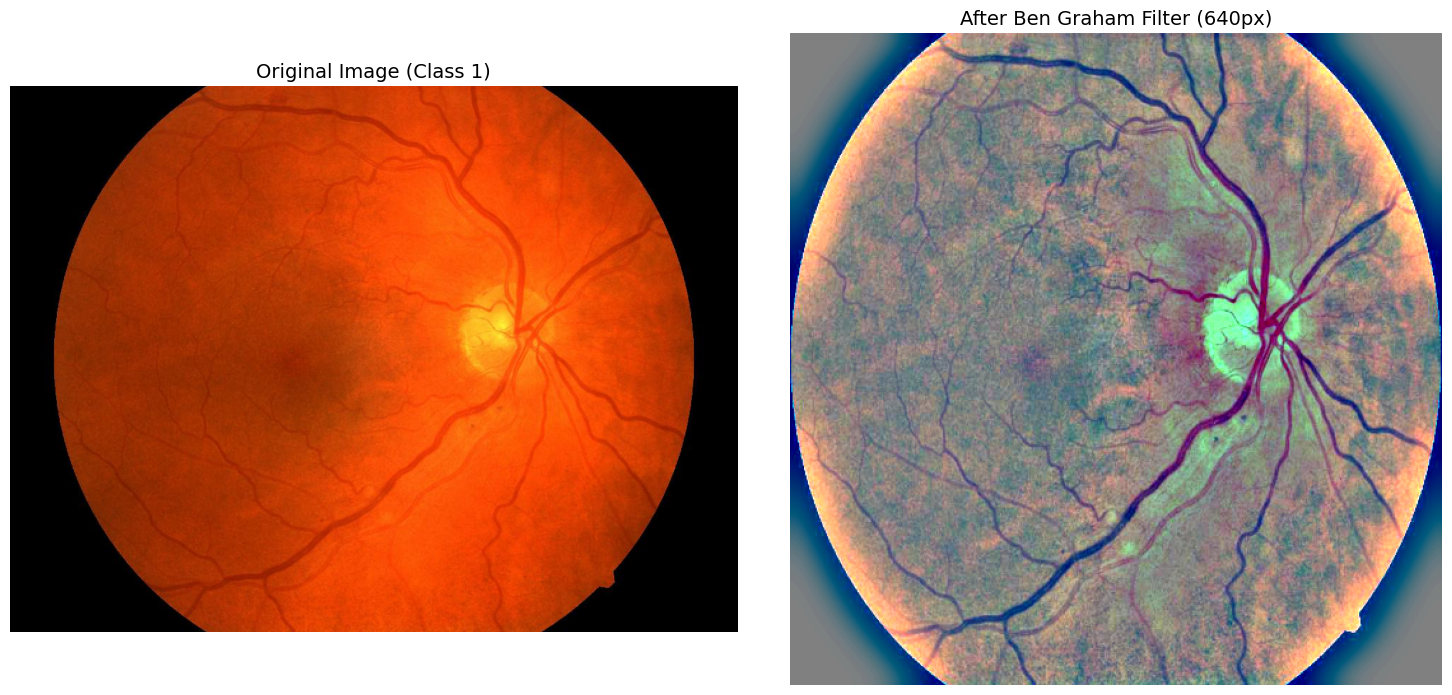

In [7]:
def showcase_preprocessing(source_dir, class_id='1'):
    # Random image from the selected class
    class_path = os.path.join(source_dir, class_id)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    
    # Read original and convert for plotting
    original_bgr = cv2.imread(img_path)
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
    
    # Apply Ben Graham filter (using your existing function)
    processed_bgr = apply_ben_graham(original_bgr) 
    processed_rgb = cv2.cvtColor(processed_bgr, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title(f"Original Image (Class {class_id})", fontsize=14)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed_rgb)
    plt.title("After Ben Graham Filter (640px)", fontsize=14)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

showcase_preprocessing(SOURCE_DIR, class_id='1')

# Summary

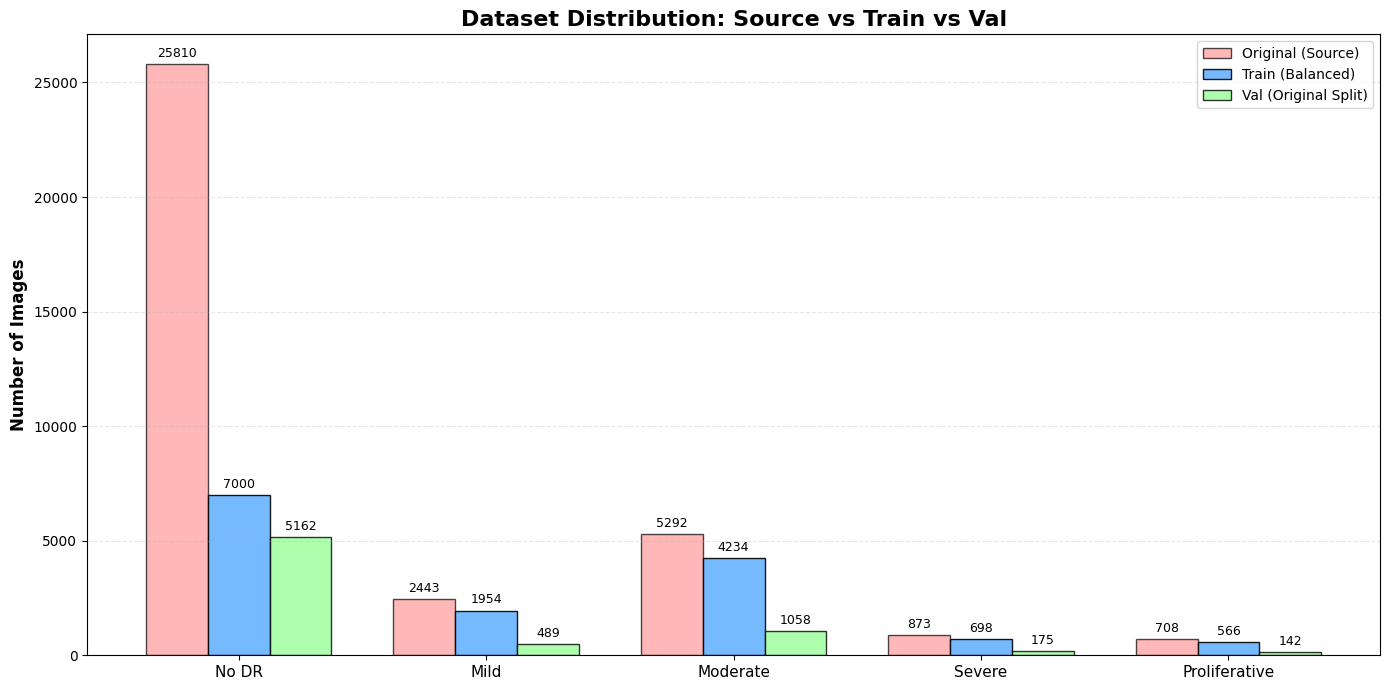

In [8]:
CLASS_MAP = {
    '0': 'No DR',
    '1': 'Mild',
    '2': 'Moderate',
    '3': 'Severe',
    '4': 'Proliferative'
}

# DYNAMIC COUNTING for 3 categories
classes = sorted(CLASS_MAP.keys())
original_counts = []
train_counts = []
val_counts = []
class_labels = [CLASS_MAP[c] for c in classes]

TRAIN_PATH = os.path.join(TARGET_DIR, "train")
VAL_PATH = os.path.join(TARGET_DIR, "val")

for cls in classes:
    # Source counts
    orig_path = os.path.join(SOURCE_DIR, cls)
    original_counts.append(len(os.listdir(orig_path)) if os.path.exists(orig_path) else 0)
    
    # Processed Train counts
    t_path = os.path.join(TRAIN_PATH, cls)
    train_counts.append(len(os.listdir(t_path)) if os.path.exists(t_path) else 0)
    
    # Processed Val counts
    v_path = os.path.join(VAL_PATH, cls)
    val_counts.append(len(os.listdir(v_path)) if os.path.exists(v_path) else 0)

x = np.arange(len(class_labels))
width = 0.25 # Width for 3 bars

fig, ax = plt.subplots(figsize=(14, 7))

# Plotting 3 distinct bars per class
rects1 = ax.bar(x - width, original_counts, width, label='Original (Source)', color='#FF9999', alpha=0.7, edgecolor='black')
rects2 = ax.bar(x, train_counts, width, label='Train (Balanced)', color='#66B2FF', alpha=0.9, edgecolor='black')
rects3 = ax.bar(x + width, val_counts, width, label='Val (Original Split)', color='#99FF99', alpha=0.8, edgecolor='black')

ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_title('Dataset Distribution: Source vs Train vs Val', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, fontsize=11)
ax.legend()

ax.bar_label(rects1, padding=3, fontsize=9, rotation=0)
ax.bar_label(rects2, padding=3, fontsize=9, rotation=0)
ax.bar_label(rects3, padding=3, fontsize=9, rotation=0)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()